## Import

In [1]:
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
# !pip -q install finance-datareader
import FinanceDataReader as fdr
import requests
import json

# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

### 한국거래소(KRX)
- [종목] http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020201
- [주식추이] http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020201

In [2]:
# 사이트에서 직접 다운로드 받는다.
code_list = pd.read_csv('data/data_0700_20231014.csv', encoding='cp949')
code_list.sample()

,표준코드,단축코드,한글 종목명,한글 종목약명,영문 종목명,상장일,시장구분,증권구분,소속부,주식종류,액면가,상장주식수
1238,KR7054800008,054800,아이디스홀딩스,아이디스홀딩스,"IDIS Holdings Co., Ltd.",2001/09/27,KOSDAQ,주권,중견기업부,보통주,500,10347756


In [3]:
code_list[['한글 종목명','단축코드','상장일','시장구분','주식종류','액면가','상장주식수']]\
.to_csv('data/krx_code_list.csv', encoding='cp949')

### 금융위원회
주식시세, 기업 정보 등을 API로 제공한다.
- [주식시세] https://www.data.go.kr/iim/api/selectAPIAcountView.do
- [기업재무정보] https://www.data.go.kr/data/15043459/openapi.do
- [공시정보] https://www.data.go.kr/data/15059649/openapi.do

In [4]:
# API 키, 데이터수, 질의 시작일자, 질의 종료일자를 입력하면 해당 기간의 주식시세를 불러오는 함수를 정의한다.
def FSC_smc(KEY, NUMOFROWS, START, END):
    total = pd.DataFrame()
    for DATE in pd.Series(pd.date_range(str(START), str(END))).dt.date.astype(str).str.replace('-',''):
        url = f'https://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo?serviceKey={KEY}&numOfRows={NUMOFROWS}&basDt={DATE}'
        result = urlopen(url) 
        stock = BeautifulSoup(result, 'lxml-xml')
        stock = pd.DataFrame([i.text.split('\n')[1:-1] for i in stock.find_all("item")], 
                              columns= ["date", "stockCode", "_", "stockName", "market", "close", "_", "_", 
                                        "open", "high", "low", "volume", "amount", "totShare", "totAmount"])
        stock = stock[[i for i in stock.columns if i != "_"]]
        total = pd.concat([total, stock])
    return total

In [5]:
key = "본인의 API키를 발급받아 입력"
nrows = 10000
start, end = 20230901, 20230905

# 거래일자, 주식코드, 주식명, 시장, 종가, 시가, 최고가, 최저가, 거래량, 거래대금, 상장주식수, 시가총액
smc = FSC_smc(key, nrows, start, end)
display(smc)

,date,stockCode,stockName,market,close,open,high,low,volume,amount,totShare,totAmount
0,20230901,900110,이스트아시아홀딩스,KOSDAQ,141,144,145,141,4167947,594074068,291932050,41162419050
1,20230901,900270,헝셩그룹,KOSDAQ,252,253,256,251,800180,202022415,85682000,21591864000
2,20230901,900260,로스웰,KOSDAQ,843,865,877,820,250955,213137681,36031288,30374375784
3,20230901,900290,GRT,KOSDAQ,3390,3675,3685,3315,1147403,3991659490,67375000,228401250000
4,20230901,900300,오가닉티코스메틱,KOSDAQ,170,169,172,167,1390610,234505501,245263481,41694791770
...,...,...,...,...,...,...,...,...,...,...,...,...
2746,20230905,900120,씨케이에이치,KOSDAQ,143,143,145,141,159232,22707211,197716999,28273530857
2747,20230905,900250,크리스탈신소재,KOSDAQ,2680,2600,2720,2600,5229043,13970616190,95891039,256987984520
2748,20230905,900070,글로벌에스엠,KOSDAQ,660,668,668,654,122822,81138960,53743968,35471018880
2749,20230905,900140,엘브이엠씨홀딩스,KOSPI,2565,2505,2595,2490,1159046,2929312300,171588411,440124274215


## FinanceDataReader
주식, 암호화폐 등의 일별 시가, 최고가, 최저가, 종가, 거래량, 변동률을 제공한다.

In [6]:
# 주식명, 질의 시작날짜, 질의 종료날짜를 입력하면 해당 기간의 주식거래 데이터를 불러오는 함수를 정의한다.
def fdr_stock(NAME, START, END):
    code = fdr.StockListing('KRX').query('Name == @NAME')['Code'].values[0]
    return fdr.DataReader(code, START, END)

In [7]:
# 예제로 삼성전자 주식을 불러온다.
samsung = fdr_stock("삼성전자", '2020-01-01', '2023-01-01')
display(samsung)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921
...,...,...,...,...,...,...
2022-12-23,58200,58400,57700,58100,9829407,-0.016920
2022-12-26,58000,58100,57700,57900,6756411,-0.003442
2022-12-27,58000,58400,57900,58100,10667027,0.003454


## 한국은행
은행, 시장지수 등을 API로 제공한다.
- [항목] https://ecos.bok.or.kr/api/#/DevGuide/StatisticalCodeSearch
  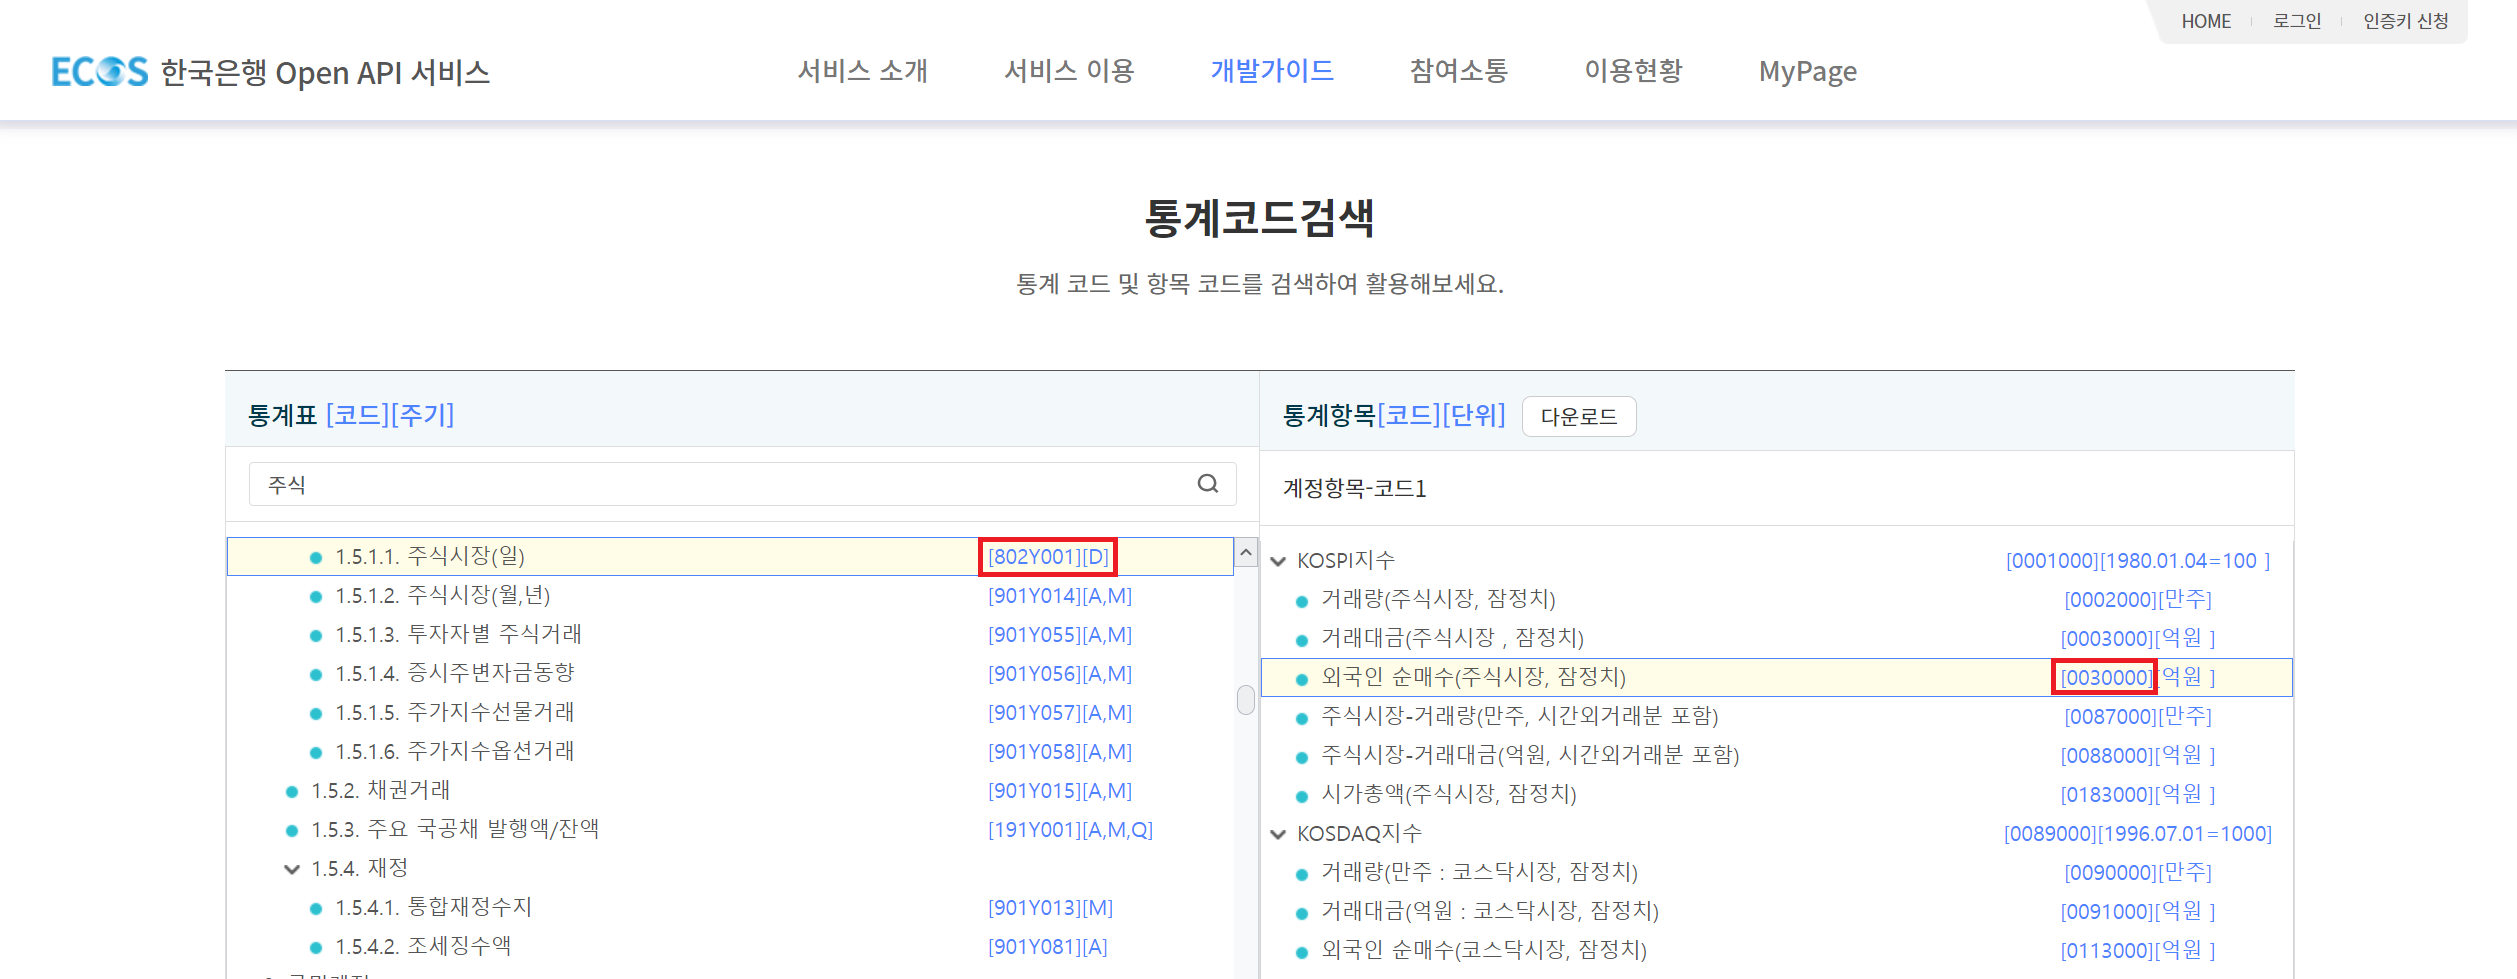

In [8]:
# API 키, 지수코드, 질의 시작날짜, 질의 종료날짜, 데이터 기간단위, 계정항목코드에 만족하는 데이터 반환 함수를 정의한다.
def Kbank(KEY, SCODE, START, END, FREQ, ICODE):
    url = f"https://ecos.bok.or.kr/api/StatisticSearch/{KEY}/json/kr/1/10000/{SCODE}/{FREQ}/{START}/{END}/{ICODE}"
    r = requests.get(url)
    ecos = json.loads(r.text)
    ecos = pd.json_normalize(ecos['StatisticSearch']['row'])
    # 시계열 데이터로 변경
    ecos['TIME'] = pd.to_datetime(ecos['TIME'], format='%Y%m%d')
    ecos.set_index('TIME', inplace=True)
    # 불필요한 데이터 제거
    ecos.drop(ecos.columns[ecos.notna().sum() <= 10], axis=1, inplace=True)
    return ecos

In [9]:
# 예시로 외국인 순매수를 추출한다.
key = "본인의 API키를 발급받아 입력"
statcode = '802Y001' # 주식시장
freq, start, end = 'D', '20100101', '20230920'
itemcode = '0030000' # 외국인 순매수

fnb = Kbank(key, statcode, start, end, freq, itemcode)
display(fnb.head())

,STAT_CODE,STAT_NAME,ITEM_CODE1,ITEM_NAME1,UNIT_NAME,DATA_VALUE
TIME,,,,,,
2010-01-04,802Y001,1.5.1.1. 주식시장(일),0030000,"외국인 순매수(주식시장, 잠정치)",억원,2390
2010-01-05,802Y001,1.5.1.1. 주식시장(일),0030000,"외국인 순매수(주식시장, 잠정치)",억원,4005
2010-01-06,802Y001,1.5.1.1. 주식시장(일),0030000,"외국인 순매수(주식시장, 잠정치)",억원,3517
2010-01-07,802Y001,1.5.1.1. 주식시장(일),0030000,"외국인 순매수(주식시장, 잠정치)",억원,2233
2010-01-08,802Y001,1.5.1.1. 주식시장(일),0030000,"외국인 순매수(주식시장, 잠정치)",억원,619
